In [35]:
import numpy as np
from cylp.cy import CyClpSimplex
from cylp.py.modeling.CyLPModel import CyLPModel, CyLPArray
import pandas as pd
import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [36]:
def var_matrix(n): # cette matrice calcule la différence de production d'énergie entre deux périodes consécutives
    M = np.zeros((n, n+1))
    for i in range(n):
        M[i,i] = -1
        M[i,i+1] = 1
    return np.matrix(M)


def matrix_sum_periods(N, T): # somme les productions d'énergie en périodes de T heures
    M = np.zeros((N//T, N))
    for i in range(N//T):
        M[i, i*T:(i+1)*T] = ([1] * T)
    
    return np.matrix(M)


def sum_by_col(matrix,N):
    sum_c = np.sum(np.array(matrix),axis = 0)
    sum_co = sum_c[:N]
    sum_co = CyLPArray(sum_co)
    return sum_co
    

def sum_rendement(rend, nb_site): # somme les rendements de chaque site sur toutes les heures / fonction objectif
    sum_rend = np.sum(rend, axis=1)
    c = np.ndarray((nb_site,))
    for i in range(nb_site):
        c[i] = sum_rend[i,0]
    c = CyLPArray(c)
    return c

def matrix_rendement(rend_off, rend_on, sites): # sélectionne les bonnes lignes des matrices de rendement
    lignes = len(rend_off)
    colonnes = len(rend_off[0])
    
    M = np.empty((lignes, colonnes))
    for i, site in sites.iterrows():
        if site['capacite offshore'] == 'Oui':
            M[i] = rend_off[i]
        else:
            M[i] = rend_on[i]
    
    return np.matrix(M)

def vecteur_OffouOn(sites, nb_sites, N):
    M1 = np.zeros(nb_sites)
    M2 = np.zeros(nb_sites)
    idx = 0
    for i, site in sites.iterrows():
        if site['capacite offshore'] == 'Oui':
            M1[idx] = cout_instal_offshore*(N/8760)
        else:
            M2[idx] = cout_instal_onshore*(N/8760)
        idx += 1
    return CyLPArray(M1 + M2)

def vector_to_matrix(vector,nb_site):
    A = np.zeros((nb_site,nb_site))
    np.fill_diagonal(A,vector)
    return A

In [205]:
# Fonction de test de validation des contraintes

def test_resultat(pays, solX, solB, solHm, solHd, solE, A, D, R):
    print('    Test de validation des contraintes pour {}'.format(pays))
    
    if pays != 'Europe':
        capacites = np.array(sites[sites['pays'] == pays]['capacites'])
    else:
        capacites = np.array(sites['capacites'])
    
    #1

    test_capacites = True
    for i in range(len(capacites)):
        if solX[i] - capacites[i] > 1e-5:
            test_capacites = False
            print('ERREUR: indice {}, {} > {}'.format(i, solX[i], capacites[i]))
    if test_capacites:
        print('test capacites: OK')

    # 2

    solBVar = np.array(var_matrix(N//T)@solB)[0]
    test_diffB = True
    for i in range(len(solBVar)):
        if abs(solBVar[i] - (A[i] + solHm[i] - solHd[i]/eta_turbinage)) > 1e-5:
            test_diffB = False
            print('ERREUR: {} != {} + {} - {}/eta'.format(solBVar[i], A[i], solHm[i], solHd[i]))
    if test_diffB:
        print('test différence barrage: OK')

    # 3

    test_demande = True
    for i in range(len(solE)):
        if D[i] - solE[i] - solHd[i] > 1e-5:
            test_demande = False
            print('ERREUR: indice {}, demande: {}, dispo: {} + {} = {}'.format(i, D[i], solE[i], solHd[i], solE[i] + solHd[i]))
    if test_demande:
        print('test demande: OK')

    # 4

    test_production = True
    for i in range(len(solE)):
        if abs( np.array(R@solX)[i] - solE[i] - solHm[i] ) > 1e-5:
            test_production = False
            print('ERREUR')
    if test_production:
        print('test production: OK')
        
    #5

    test_stockage = True
    for i in range(len(solB)):
        if solB[i]  <= -1e-5 or solB[i] - 1e-5 >= stockage_hydro.sum():
            test_stockage = False
            print('ERREUR: 0 < {} < {}'.format(solB[i],stockage_hydro.sum()))
    if test_stockage:
        print('test stockage : OK')
            
    #6
    
    test_pompage = True
    for i in range(len(solHm)):
        if solHm[i]  <= -1e-5 or solHm[i] - 1e-5 >= T*p_pompage.sum():
            test_pompage = False
            print('ERREUR:  0 < {} < {}'.format(solHm[i],T*p_pompage.sum()))
    if test_pompage:
        print('test pompage: OK')
    
    #7
    
    test_turbinage = True
    for i in range(len(solHd)):
        if solHd[i]  <= -1e-5 or solHd[i] - 1e-5 >= T*p_turbinage.sum():
            test_turbinage = False
            print('ERREUR: 0 < {} < {}'.format(solHd[i],T*p_turbinage.sum()))
    if test_turbinage:
        print('test turbinage: OK')

    





In [203]:
# chargement des données pour tout le projet

nb_site = 642

sites = pd.read_csv('data/Sites.csv')
sites = sites.sort_values('index site')
sites = sites.reset_index()
capacites = sites['capacites'].copy()
capacites = CyLPArray(capacites) # shape: (642,)


off_cap = sites['capacite offshore']
off_cap = off_cap.replace('Oui', 1)
off_cap = off_cap.replace('Non', 0)
off_cap = CyLPArray(off_cap)


rend_off_entire = np.genfromtxt('data/Rendements_offshore.csv', delimiter=',')
rend_on_entire = np.genfromtxt('data/Rendements_onshore.csv', delimiter=',')

#---------------------------------


# Consommation électrique (demande) par pays et par heure (matrice : ligne = pays, colonne = heure)
consommations_entire = np.genfromtxt('data/Consommations.csv', delimiter=',') # shape: (15, 8760)

# Couts d'installation amortis des éoliennes
cout_instal_onshore  = 168903 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
cout_instal_offshore = 300336 # Coût *amorti sur un an* pour l'installation d'un MW éolien on-shore (euros/MW/an)
 
# Couts d'installation et de fonctionnement des centrales au gaz
cout_amorti_gaz = 94956 # Coût *amorti sur un an* pour l'installation d'un MW de centrale au gaz (euros/MW/an)
cout_fonct_gaz  = 65    # Coût de fonctionnement pour la production d'un MWh par centrale au gaz (euros/MWh)

## Données hydroélectriques 

# Stockage disponible par pays (en MWh)
stockage_hydro = np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6])

# Puissances maximales de turbinage et de pompage disponibles par pays (en MW)
p_turbinage = np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101])
p_pompage = np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ])

eta_turbinage = 0.75 # Rendement pour le turbinage (sans unité)

# Apports naturels au stockagep par pays et par heure
apports_entire = np.genfromtxt('data/Apports-hydro.csv', delimiter=',') # shape: (15, 8760)

liste_pays = ['Allemagne','Autriche','Belgique','Danemark','Espagne','France','Irlande','Italie','Luxembourg',\
             'Norvège','Pays-Bas','Portugal','Royaume-Uni','Suède','Suisse']

## Situation II.1

In [183]:
# Fonction de résolution de la situation II.1

def resolution_prob1(N, T, verbose = True,analyse_post_op = False):
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(N//T + 1)) 
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    
    # Variable
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    
    model.addConstraint(0 <= X <= capacites, 'capacitee')
    
    if analyse_post_op == True :
        model.addConstraint(0 <= B + 0 <= M,'capa_stockage_hydro')
        model.addConstraint(0 <= H_m +0 <= T*P_p,'ajout_énergie_hydro')
        model.addConstraint(0 <= H_d + 0<= T*P_t,'hydro_vers_conso')
        model.addConstraint(B[0] +0 == M/2,'capa_init_hydro')
        model.addConstraint(B[-1] + 0 == M/2,'capa_final_hydro')
        
    else :
        model.addConstraint(0 <= B <= M,'capa_stockage_hydro')
        model.addConstraint(0 <= H_m <= T*P_p)
        model.addConstraint(0 <= H_d <= T*P_t)
        model.addConstraint(B[0] == M/2,'capa_init_hydro')
        model.addConstraint(B[-1] == M/2,'capa_final_hydro')
    


    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    model.objective =  C * X

    s = CyClpSimplex(model)

    start = time.time()
    result = s.dual()
    end = time.time()

    if verbose:
        print("résolution:", result)

    return s, (end-start), D , A , R , M

In [207]:
# Résolution de la situation II.1

N = 8760
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s, time_taken, D, A, R, M = resolution_prob1(N,T)
solHd = s.primalVariableSolution['H_d']
solE  = s.primalVariableSolution['E']
solB  = s.primalVariableSolution['B']
solX  = s.primalVariableSolution['X']
solHm = s.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} €".format(s.objectiveValue))
print("pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : {:.2f} %".format(solHd.sum() *100 /(solHd.sum() + solE.sum())))
print("pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: {:.2f} %".format(solHm.sum()*100 /(solE.sum() + solHm.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s.objectiveValue/(D.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))

N = 8760
T = 3
Nombre de site = 642

résolution: optimal
prix total de la production de l'énergie éléctrique : 150961169167.05 €
pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : 14.56 %
pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: 5.20 %
prix moyen d'éléctricité consommée : 58.28 €/MWh
Temps de résolution: 0 min 8.428 sec


In [208]:
# Test de validation

test_resultat('Europe', solX, solB, solHm, solHd, solE, A, D, np.array(R))

    Test de validation des contraintes pour Europe
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK
test stockage : OK
test pompage: OK
test turbinage: OK


### Graphes des résultats

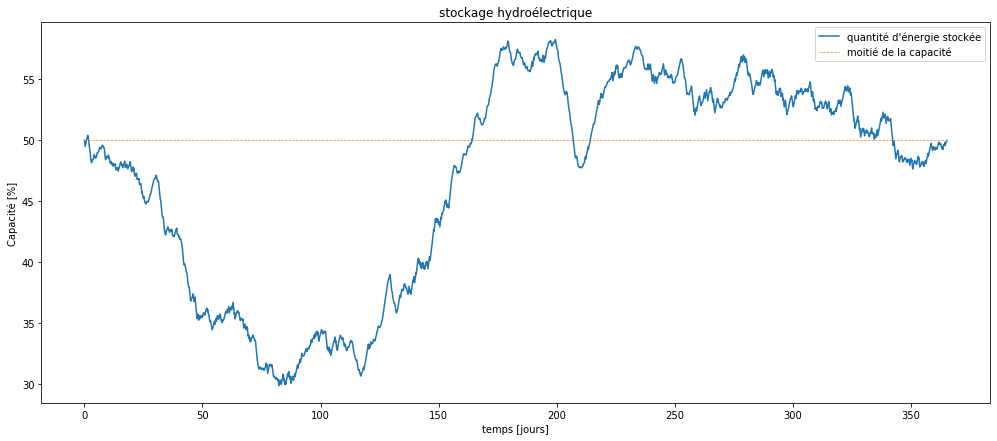

In [130]:
# Plot stockage hydroélectrique

X = np.arange(T, N+T, T)
Xb = np.arange(T, N+2*T, T)

plt.figure(figsize=(17,7))
plt.plot(Xb/24, solB/M*100)
plt.plot(Xb/24, [50]*len(solB), '--', linewidth=0.7)
plt.title('stockage hydroélectrique')
plt.legend(['quantité d\'énergie stockée', 'moitié de la capacité'])
plt.xlabel('temps [jours]')
plt.ylabel('Capacité [%]')
plt.show()

On peut voir que jusqu'aux 100 premiers jours la quantité d'énergie stockée ne fait que descendre car cela correspond à une période où la consommation est élevée tandis que des jours 120 à 170 la quantité d'énergie stockée remonte très fort car la consommation en électricité baisse.

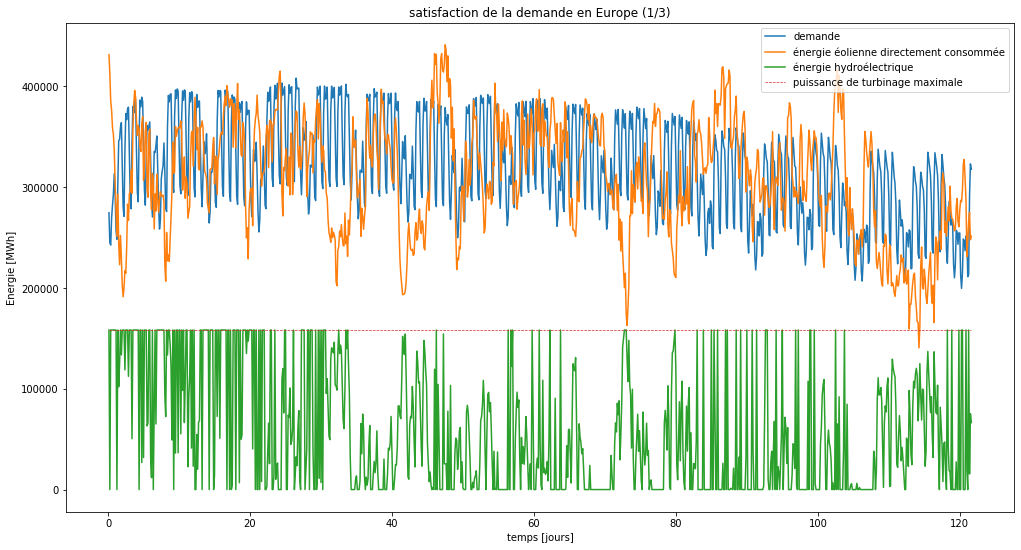

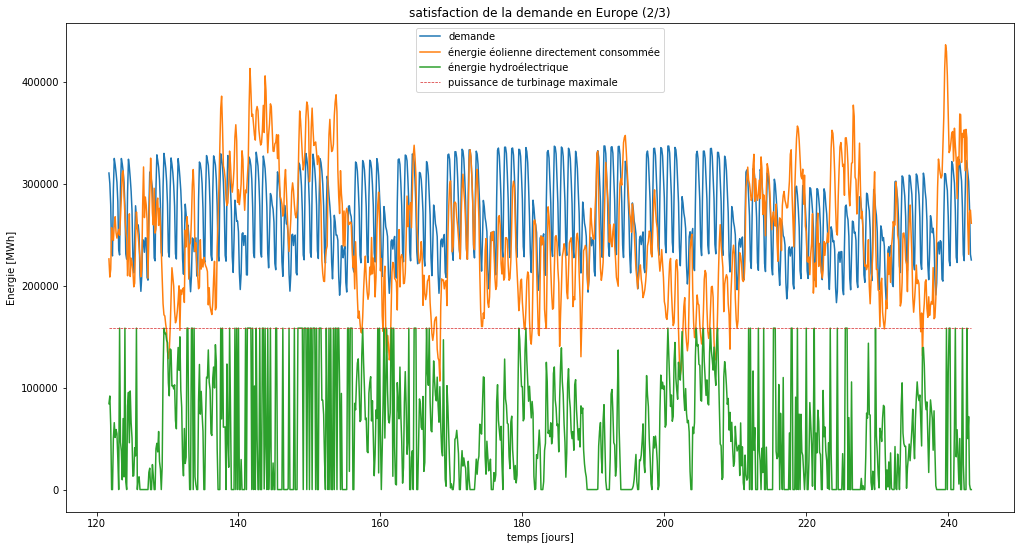

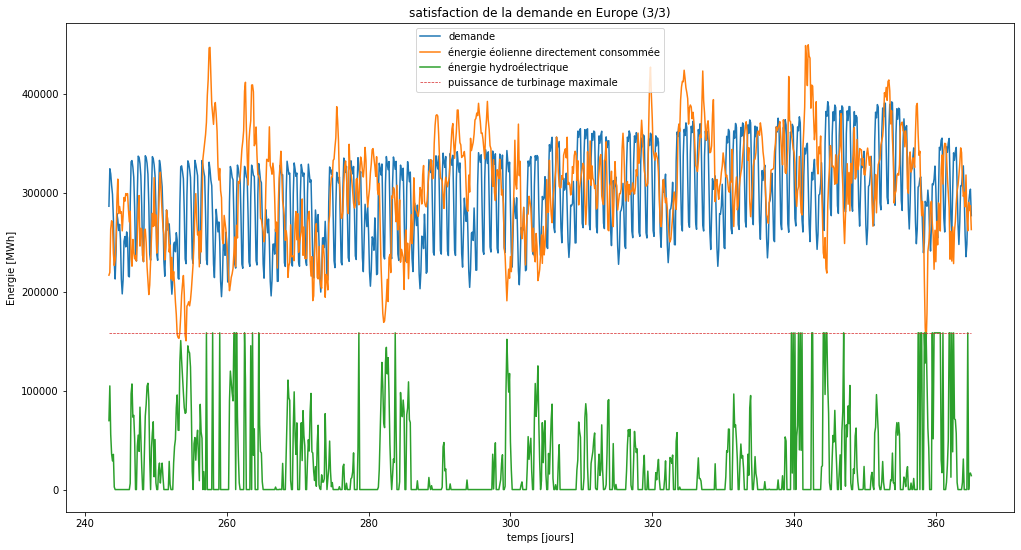

In [102]:
# Plot satisfaction de la demande

borne1 = N//T//3
borne2 = N//T//3*2

# satisfaction de la demande 1/3

plt.figure(figsize=(17,9))
plt.plot(X[:borne1]/24, D[:borne1]/T)
plt.plot(X[:borne1]/24, solE[:borne1]/T)
plt.plot(X[:borne1]/24, solHd[:borne1]/T)
plt.plot(X[:borne1]/24, [p_turbinage.sum()] * len(X[:borne1]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (1/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

# satisfaction de la demande 2/3

plt.figure(figsize=(17,9))
plt.plot(X[borne1:borne2]/24, D[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, solE[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, solHd[borne1:borne2]/T)
plt.plot(X[borne1:borne2]/24, [p_turbinage.sum()] * len(X[borne1:borne2]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (2/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

# satisfaction de la demande 3/3

plt.figure(figsize=(17,9))
plt.plot(X[borne2:]/24, D[borne2:]/T)
plt.plot(X[borne2:]/24, solE[borne2:]/T)
plt.plot(X[borne2:]/24, solHd[borne2:]/T)
plt.plot(X[borne2:]/24, [p_turbinage.sum()] * len(X[borne2:]), '--', linewidth=0.7)
plt.title('satisfaction de la demande en Europe (3/3)')
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'puissance de turbinage maximale'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

## Analyse post-optimale

Etant donné que beaucoup de nos contraintes sont en réalité considérées comme des simples bornes sur nos variables, nous avons mis un paramètre à la fonction qui nous permet de résoudre le problème lorsque nous avons besoin des variables duales c'est à dire lorsque les bornes doivent être considérées par le solveur comme des contraintes.
(Pour éviter d'avoir un modèle plus lent lorsque ce n'est pas nécessaire.)
Regardons maintenant combien rapporterait l'installation d'un MWh supplémentaire de stockage.
Pour cela nous allons regarder les variables du problème dual associées aux contraintes du problème primal qui sont impactées par un changement de la capacité de stockage hydroéléctriques. Il y a trois contraintes du problème primal qui varie lorsque la capacité de sotckage augmente. Ce sont les contraintes 'capa_stockage_hydro' , 'capa_init_hydro' , 'capa_final_hydro'. On peut voir que les variables duales associées à la contrainte 0 <= B <= M sont toujours nulle , ce qui se comprend assez aisément en observant le graphe. En effet on peut voir que pour notre solution optimale, la capacité hydroéléctrique maximale n'est jamais atteinte. Dès lors une augmentation de stockage ne modifie pas la valeur optimale. Les deux variables duales associées aux deux autres contraintes ont toujours des valeurs opposées (pourquoi ?). Ceci nous permet de voir que l'augmentation de la capacité de stockage n'aurait pas d'utilité.

In [209]:
s = resolution_prob1(8760,T,analyse_post_op = True)[0]

var_duale_hydro = s.dualConstraintSolution['capa_stockage_hydro']
var_duale_init  = s.dualConstraintSolution['capa_init_hydro']
var_duale_final = s.dualConstraintSolution['capa_final_hydro']

print(var_duale_init)
print(var_duale_final)
print(var_duale_hydro)


résolution: optimal
[0.]
[0.]
[0. 0. 0. ... 0. 0. 0.]


Regardons maintenant ce qu'il en est si l'on augmente de un MW la puissance de pompage. Pour cela regardons les variables duales associées à la contrainte appelée "ajout énergie hydro". C'est en effet la seule contrainte impactée lors d'une modification de la puissance de pompage.

In [210]:
var_duale_ajout_energie_hydro = s.dualConstraintSolution['ajout_énergie_hydro']
print(sum(var_duale_ajout_energie_hydro))

527920.2623865787


In [211]:
var_duale_turbi = s.dualConstraintSolution['hydro_vers_conso']
print(var_duale_turbi.sum())


-527920.2623865786


## Situation II.2

In [77]:
def resolution_prob2(N, T):
    
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    M = stockage_hydro.sum() # scalar 
    P_p = p_pompage.sum() # scalar
    P_t = p_turbinage.sum() # scalar

    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    I = np.matrix(np.eye(nb_site)) # shape: (642, 642)
    A = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(apports,N))[0] # shape: (N/T,)
    D = CyLPArray(matrix_sum_periods(N, T)@sum_by_col(consommations, N))[0] # shape: (N/T,)
    R = np.matrix(matrix_sum_periods(N,T)@rend.T) # shape: (N/T, 642)
    
    half_capacites = capacites / 2
    matrix_capa = vector_to_matrix(half_capacites,nb_site)
    
    
    # Variables
    model = CyLPModel()
    X   = model.addVariable('X', nb_site)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)


    # Contraintes
    model.addConstraint(E + H_d >= D)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)
    model.addConstraint((R@matrix_capa)*X - E - H_m == 0)

    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(0 <= X <= 2)
    
    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)
    
    
    # Objectif
    C = vecteur_OffouOn(sites, nb_site, N)
    O = C @ matrix_capa
    model.objective = O*X
    
    
    
    s = CyClpSimplex(model)
    s.setInteger(X)
    cbcModel = s.getCbcModel()
    
    start = time.time()
    cbcModel.branchAndBound()
    end = time.time()
    

    
    return cbcModel, (end-start), D

In [14]:
N = 7*24
T = 3

print("N = {}\nT = {}\nNombre de site = {}\n".format(N, T,nb_site))

s2 , time_taken , D2  = resolution_prob2(N,T)
solHd2 = s2.primalVariableSolution['H_d']
solE2  = s2.primalVariableSolution['E']
solB2  = s2.primalVariableSolution['B']
solX2  = s2.primalVariableSolution['X']
solHm2 = s2.primalVariableSolution['H_m']

print("prix total de la production de l'énergie éléctrique : {:.2f} €".format(s2.objectiveValue))
print("pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : {:.2f} %".format(solHd2.sum() *100 /(solHd2.sum() + solE2.sum())))
print("pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: {:.2f} %".format(solHm2.sum()*100 /(solE2.sum() + solHm2.sum())))
print("prix moyen d'éléctricité consommée : {:.2f} €/MWh".format(s2.objectiveValue/(D2.sum())))
print("Temps de résolution: {:.0f} min {:.3f} sec".format(time_taken//60, time_taken % 60))

N = 168
T = 3
Nombre de site = 642

prix total de la production de l'énergie éléctrique : 2282789266.00 €
pourcentage de la production d'énergie qui vient des capacités hydroéléctrique : 9.68 %
pourcentage de l'énergie produite par les éoliennes qui est convertie en énergie potentielle: 3.08 %
prix moyen d'éléctricité consommée : 41.63 €/MWh
Temps de résolution: 0 min 41.432 sec


## Graphe du temps d'éxecution en fonction du nombre d'heures considérées

In [16]:
N = 2500


temps_exec_prob1 = []
temps_exec_prob2 = []
N_vector = np.array([(i+1)*N//7 for i in range(7)])
    

for N_ in N_vector:    
    temps_exec_prob1.append(resolution_prob1(N_, T,verbose=False)[1])

for N_ in N_vector[:4]:    
    temps_exec_prob2.append(resolution_prob2(N_, T)[1])

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

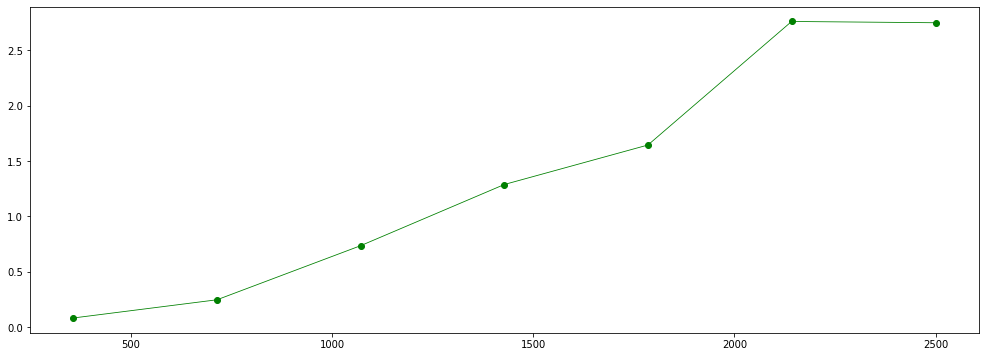

In [17]:
plt.figure(figsize=(17,6))
plt.plot(N_vector, temps_exec_prob1, '-og', linewidth=0.8)
plt.plot(N_vector[:4], temps_exec_prob2, '-or', linewidth=0.8)
plt.xlabel('quantité de donnée prise en compte [heure]')
plt.ylabel('temps d\'exécution des fonctions [seconde]')
plt.title('graphe temps d\'exécution en fonction de la quantité de donnée')
plt.grid()
plt.legend(['temps d\'exécution problème1', 'temps d\'éxecution problème2'])
plt.show()

## Situation II.3

In [80]:
def resolution_prob3(N, T, pays, verbose=True):
    
    i = liste_pays.index(pays)
    
    apports = apports_entire[:,:N] # shape: (15, N)
    consommations = consommations_entire[:,:N] # shape: (15, N)
    rend_off = rend_off_entire[:,:N] # shpae: (642, N)
    rend_on = rend_on_entire[:,:N] # shape: (642, N)
    rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)
    
    sites_pays = sites[sites['pays'] == pays]
    apports_pays = apports[i]
    consommations_pays = consommations[i]
    nb_sites_pays = len(sites_pays)
    capacites_pays = sites[sites['pays']==pays]['capacites']
    
    rend_pays = np.matrix(np.empty((nb_sites_pays, N))) # shape: (nb_sites_pays, N)
    for idx, j in enumerate(np.array(sites_pays['index site'])):
        rend_pays[idx] = np.array(rend)[j]
    
    M = stockage_hydro[i]
    P_p = p_pompage[i]
    P_t = p_turbinage[i]
    
    I = np.matrix(np.eye(nb_sites_pays))
    A = CyLPArray(matrix_sum_periods(N, T)@apports_pays)[0]
    D = CyLPArray(matrix_sum_periods(N, T)@consommations_pays)[0]
    R = np.matrix(matrix_sum_periods(N,T)@rend_pays.T)
    
    model = CyLPModel()
    X   = model.addVariable('X', nb_sites_pays)
    B   = model.addVariable('B', N//T +1 )
    H_m = model.addVariable('H_m', N//T )
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T )


    # Contraintes
    model.addConstraint(E + H_d >= D)
    if R.shape[1] == 1:
        model.addConstraint(X*R - E - H_m == 0)
    else:
        model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)

    model.addConstraint(0 <= X <= capacites_pays, 'capacitee')
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)

    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)


    # Objectif
    C = vecteur_OffouOn(sites_pays, nb_sites_pays, N)
    model.objective =  C * X


    s = CyClpSimplex(model)
    
    start = time.time()
    result = s.dual()
    end = time.time()
    
    if verbose:
        print('{}: {}'.format(pays, result))
    
    return result, s, (end-start), np.array(D), np.array(A), np.array(R)

In [118]:
# Paramètres
N = 8760
T = 3

for pays in liste_pays:
    res = resolution_prob3(N, T, pays)
    
    if res[0] == 'optimal':
        print('    Prix: {:.2f} euros/MWh'.format(res[1].objectiveValue/res[3].sum()))
        energieProduite = (res[5]@res[1].primalVariableSolution['X']).sum()
        energieConsommee = res[3].sum()
        print('    Energie consommée / énergie éolienne produite: {:.2f}%'.format(energieConsommee/energieProduite*100))

Allemagne: primal infeasible
Autriche: primal infeasible
Belgique: primal infeasible
Danemark: primal infeasible
Espagne: optimal
    Prix: 68.00 euros/MWh
    Energie consommée / énergie éolienne produite: 77.92%
France: primal infeasible
Irlande: primal infeasible
Italie: primal infeasible
Luxembourg: primal infeasible
Norvège: optimal
    Prix: 7.06 euros/MWh
    Energie consommée / énergie éolienne produite: 603.88%
Pays-Bas: primal infeasible
Portugal: primal infeasible
Royaume-Uni: primal infeasible
Suède: optimal
    Prix: 46.58 euros/MWh
    Energie consommée / énergie éolienne produite: 120.47%
Suisse: optimal
    Prix: 37.08 euros/MWh
    Energie consommée / énergie éolienne produite: 214.67%


On voit dans les résultats que la Norvège obtient un prix incroyable de 7 euros/MWh d'électricité consommé, cela peut s'expliquer par la rapport énergie consommée / énergie éolienne produite valant plus 6 ce qui veut dire qu'une grande partie de sa consommation d'électricité vient en fait des apports naturels en eau dans les reserves hydroélectriques qui ne lui coûte absolument rien. Il en est de même pour la Suisse et la Suède.

Touts les autres pays, hormis l'Espagne, ne disposent pas d'assez de puissance pompage-turbinage pour satisfaire leur consommation lors des périodes avec moins de vent, ce qui explique pourquoi le solveur ne trouve pas de solution possible au problème.

### Exemple 1: l'Allemagne, pas de solution possible

Allemagne: primal infeasible


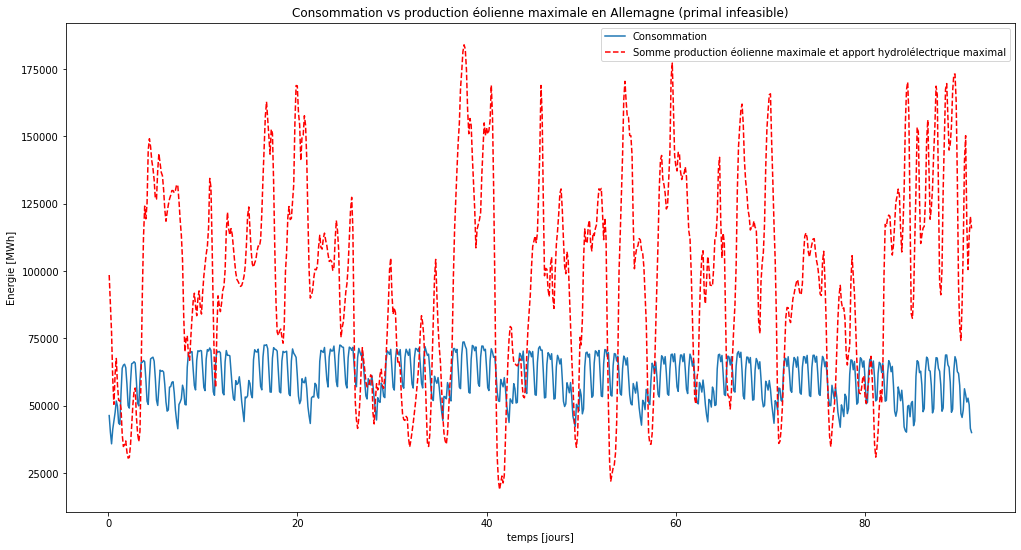

In [111]:
pays = 'Allemagne'
N = 8760//4
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)
capacites_pays = np.array(sites[sites['pays'] == pays]['capacites'])

X = np.arange(T, N+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D/T) # Consommation
plt.plot(X/24, R@capacites_pays/T + p_turbinage[liste_pays.index(pays)], '--r') # Production éolienne maximale + apport hydrolélectrique
plt.title('Consommation vs production éolienne maximale en {} ({})'.format(pays, result))
plt.legend(['Consommation', 'Somme production éolienne maximale et apport hydrolélectrique maximal'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

L'Allemagne, comme beaucoup d'autres pays, ne peux pas satisfaire entièremment sa consommation électrique uniquement par l'éolien et l'hydrolélectrique. Sur le graphe ci-dessus, la courbe en rouge pointillé représente l'énergie maximale que l'Allemagne pourrait produire à chaque période de temps, c'est-à-dire si les turbines hydroélectriques fonctionnaient 24h/24 et si toutes la puissance éolienne possible étaient installée (situation évidemment impossible). L'on remarque que cette courbe de production maximale passe souvent en dessous de celle de la consommation électrique, ce qui veut dire que assez régulièremment la population Allemande subira des épisodes de pénuries d'électricité même si en moyenne elle produit plus d'électricité qu'elle en consomme.

### Exemple 2: la Norvège, production basée sur l'hydroélectrique

Norvège: optimal


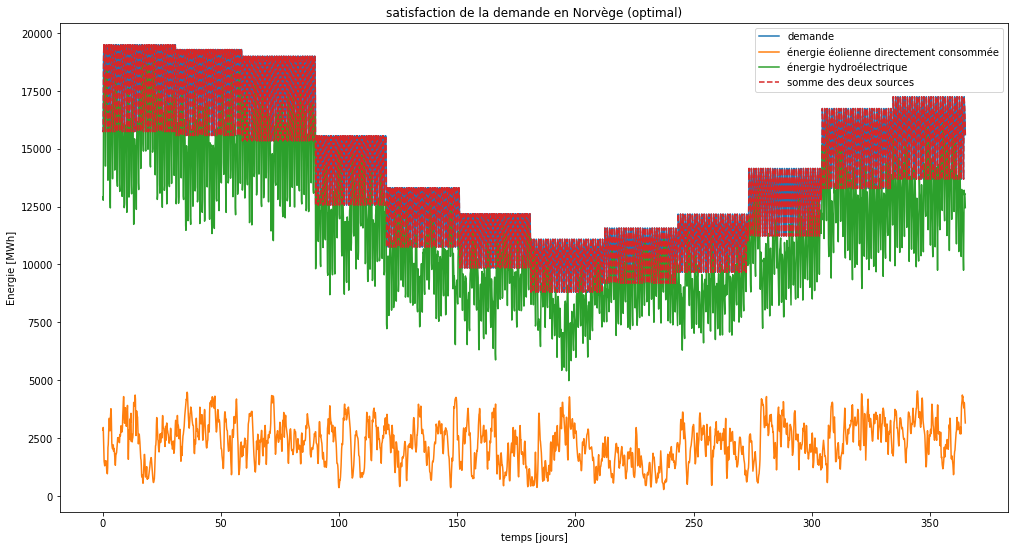

    Test de validation des contraintes pour Norvège
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK


In [147]:
pays = 'Norvège'
N = 8760
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)

X = np.arange(T, N+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D/T) # Consommations
plt.plot(X/24, s.primalVariableSolution['E']/T)
plt.plot(X/24, s.primalVariableSolution['H_d']/T)
plt.plot(X/24, s.primalVariableSolution['E']/T + s.primalVariableSolution['H_d']/T, '--')
plt.title('satisfaction de la demande en {} ({})'.format(pays, result))
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'somme des deux sources'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

test_resultat(pays, s.primalVariableSolution['X'], s.primalVariableSolution['B'], s.primalVariableSolution['H_m'], s.primalVariableSolution['H_d'], s.primalVariableSolution['E'], A, D, R)

total des apports naturels: 136366154.7 MWh
total de la consomaation  : 122572078.7 MWh
perte d'énergie           : 0.00000 MWh


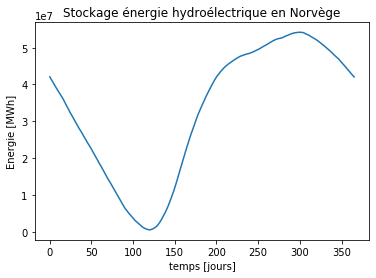

In [149]:
i = liste_pays.index(pays)
print('total des apports naturels: {} MWh'.format(apports_entire[i].sum()))
print('total de la consomaation  : {} MWh'.format(consommations_entire[i].sum(), 'MWh'))
print('perte d\'énergie           : {:.5f} MWh'.format((s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum()))

plt.plot(np.arange(T, N+2*T, T)/24, s.primalVariableSolution['B'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.title('Stockage énergie hydroélectrique en {}'.format(pays))
plt.show()

Dans le cas de la Norvège on remarque que la majorité de la production d'électricité vient de l'hydroélectrique. En fait, si on compare le total des apports naturels hydroélectrique au total de la consommation, on voit que les apports naturels surpassent légèremment la consommation donc, en théorie, la Norvège pourrait totalement se passer de l'éolien pour satisfaire sa consommation nationale mais elle en a quand même besoin pour reremplir ses stocks hydroélectrique lorsque les périodes de grande consommation sont trop longue (l'hiver, jour 0 - 120) et que les stocks descendent trop bas.

De plus la Norvège possède la plus grande puissance de turbinage d'Europe ce qui lui permet d'être indépendante de la variabilité du vent. Lorsqu'il y a beaucoup de vent, les turbines tournent moins et les barrages se chargent tandis que quand il n'y a pas de vent, les turbines peuvent produire beaucoup plus et toujours satisfaire la consommation. Cette flexibilitée lui permet aussi de ne jamais gaspiller d'énergie, on peut le voir sur le graphe grâce au fait que la somme des deux sources d'électricité est toujours égale à la consommation.

### Exemple 3: l'Espagne

Espagne: optimal


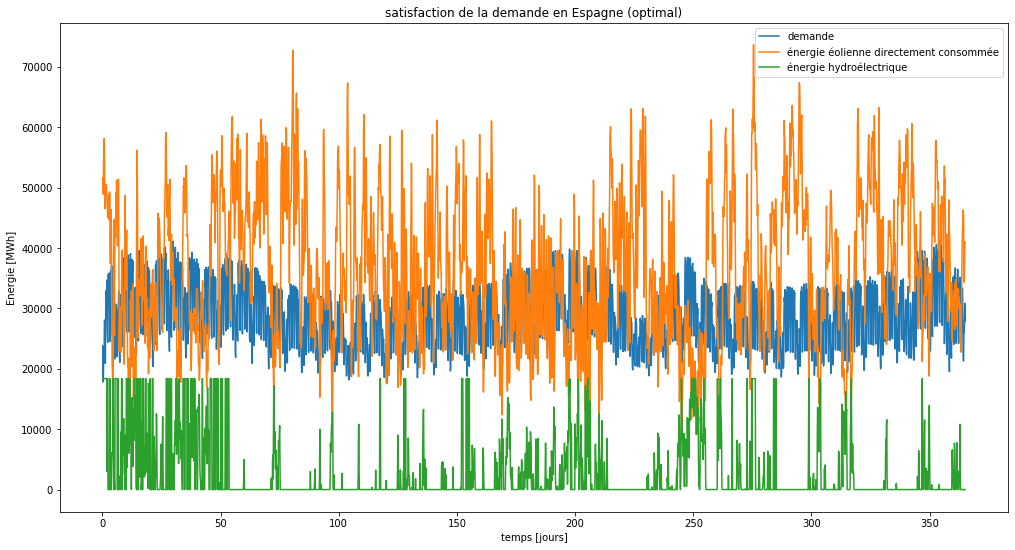

    Test de validation des contraintes pour Espagne
test capacites: OK
test différence barrage: OK
test demande: OK
test production: OK


In [171]:
pays = 'Espagne'
N = 8760
T = 3

result, s, t, D, A, R = resolution_prob3(N, T, pays)

X = np.arange(T, N+T, T)

plt.figure(figsize=(17,9))
plt.plot(X/24, D/T) # Consommations
plt.plot(X/24, s.primalVariableSolution['E']/T)
plt.plot(X/24, s.primalVariableSolution['H_d']/T)
#plt.plot(X/24, s.primalVariableSolution['E']/T + s.primalVariableSolution['H_d']/T, '--')
plt.title('satisfaction de la demande en {} ({})'.format(pays, result))
plt.legend(['demande', 'énergie éolienne directement consommée', 'énergie hydroélectrique', 'somme des 2 inputs'])
plt.xlabel('temps [jours]')
plt.ylabel('Energie [MWh]')
plt.show()

test_resultat(pays, s.primalVariableSolution['X'], s.primalVariableSolution['B'], s.primalVariableSolution['H_m'], s.primalVariableSolution['H_d'], s.primalVariableSolution['E'], A, D, R)

In [172]:
print('puissance de turbinage / consommation moyenne : {:.2f} %'.format(p_turbinage[liste_pays.index('Espagne')]/consommations_entire[liste_pays.index('Espagne')].sum()*8760*100))
print('perte d\'énergie                               : {:.2f} MWh ({:.2f} % de la consommation totale)'.format((s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum(), (s.primalVariableSolution['E'] + s.primalVariableSolution['H_d'] - D).sum() / D.sum() *100))

puissance de turbinage / consommation moyenne : 63.52 %
perte d'énergie                               : 91243391.64 MWh (36.01 % de la consommation totale)


l'Espagne a réussi à avoir une solution au problème grâce à sa relativement grande puissance de turbinage par rapport à sa consommation et au fait qu'il n'y ai pas eu de période avec trop peu de production d'énergie éolienne. Par contre il y a eu énormément de gaspillage d'énergie (environ 36% de la consommation totale). C'est dû au fait que l'Espagne a dû installer une grande puissance éolienne pour les périodes avec peu de vent mais en contrepartie il y a du surplus lorsqu'il y a beaucoup de vent. Cela explique le fait que le prix moyen en Espagne soit de 68 euros/MWh.

### Situation II.4

In [301]:
# Paramètres
N = 24*7
T = 3

# Constantes
apports = apports_entire[:,:N] # shape: (15, N)
consommations = consommations_entire[:,:N] # shape: (15, N)
rend_off = rend_off_entire[:,:N] # shpae: (642, N)
rend_on = rend_on_entire[:,:N] # shape: (642, N)
rend = matrix_rendement(rend_off, rend_on, sites) # shape: (642, N)

solB_pays = []
solX_pays = []
solHm_pays = []
solHd_pays = []
solE_pays = []
solG_pays = []
solGinst_pays = []
D_pays = []
R_pays = []
A_pays = []
capa_pays = []
result_pays = []
objectif_pays = []
for i, pays in enumerate(liste_pays):
    sites_pays = sites[sites['pays'] == pays]
    apports_pays = apports[i]
    consommations_pays = consommations[i]
    nb_sites_pays = len(sites_pays)
    capacites_pays = sites[sites['pays']==pays]['capacites']
    
    rend_pays = np.matrix(np.empty((nb_sites_pays, N))) # shape: (nb_sites_pays, N)
    for idx, j in enumerate(np.array(sites_pays['index site'])):
        rend_pays[idx] = np.array(rend)[j]
    
    M = stockage_hydro[i]
    P_p = p_pompage[i]
    P_t = p_turbinage[i]
    
    I = np.matrix(np.eye(nb_sites_pays))
    A = CyLPArray(matrix_sum_periods(N, T)@apports_pays)[0]
    D = CyLPArray(matrix_sum_periods(N, T)@consommations_pays)[0]
    R = np.matrix(matrix_sum_periods(N,T)@rend_pays.T)
    
    model = CyLPModel()
    X   = model.addVariable('X', nb_sites_pays)
    B   = model.addVariable('B', N//T + 1)
    H_m = model.addVariable('H_m', N//T)
    H_d = model.addVariable('H_d', N//T)
    E   = model.addVariable('E', N//T)
    G   = model.addVariable('G', N//T)
    G_inst = model.addVariable('Ginst', 1)


    # Contraintes
    model.addConstraint(E + H_d + G >= D)
    if R.shape[1] == 1:
        model.addConstraint(X*R - E - H_m == 0)
    else:
        model.addConstraint(R*X - E - H_m == 0)
    model.addConstraint(var_matrix(N//T)*B - H_m + np.matrix(np.eye(N//T)/eta_turbinage)*H_d == A)

    model.addConstraint(0 <= X <= capacites_pays, 'capacitee')
    model.addConstraint(0 <= B <= M)
    model.addConstraint(0 <= H_m <= T*P_p)
    model.addConstraint(0 <= H_d <= T*P_t)
    model.addConstraint(0 <= G)
    #model.addConstraint(G - CyLPArray(G_inst*np.ones(N//T)) <= 0)

    model.addConstraint(B[0] == M/2)
    model.addConstraint(B[-1] == M/2)


    # Objectif
    C = vecteur_OffouOn(sites_pays, nb_sites_pays, N)
    g_fonct = CyLPArray(cout_fonct_gaz*np.ones(N//T))
    model.objective =  C * X + g_fonct * G #+ G_inst * (cout_amorti_gaz * N / 8760)


    s = CyClpSimplex(model)

    result = s.dual()
    print('    ', pays, ':')
    print(result)
    if result == 'optimal':
        print('solution    :', s.objectiveValue)
        #print('prod:', (R@s.primalVariableSolution['X']).sum())
        print('prix par MWh:', s.objectiveValue/(R@s.primalVariableSolution['X']).sum())
    print()
    
    solB_pays.append(s.primalVariableSolution['B'])
    solX_pays.append(s.primalVariableSolution['X'])
    solHm_pays.append(s.primalVariableSolution['H_m'])
    solHd_pays.append(s.primalVariableSolution['H_d'])
    solE_pays.append(s.primalVariableSolution['E'])
    solG_pays.append(s.primalVariableSolution['G'])
    solGinst_pays.append(s.primalVariableSolution['Ginst'])
    D_pays.append(D)
    R_pays.append(np.array(R))
    A_pays.append(A)
    capa_pays.append(np.array(capacites_pays))
    result_pays.append(result)
    objectif_pays.append(s.objectiveValue)

     Allemagne :
optimal
solution    : 462226503.18665546
prix par MWh: 78.82009707978649

     Autriche :
optimal
solution    : 46605958.912949756
prix par MWh: 121.25917856898072

     Belgique :
optimal
solution    : 112013266.51006787
prix par MWh: 177.8004893466418

     Danemark :
optimal
solution    : 34782503.060806125
prix par MWh: 56.223464546706175

     Espagne :
optimal
solution    : 130447780.17295852
prix par MWh: 31.5016862399948

     France :
optimal
solution    : 480896912.97760296
prix par MWh: 47.145817789375435

     Irlande :
optimal
solution    : 24440024.407997556
prix par MWh: 52.8104008405713

     Italie :
optimal
solution    : 232265055.95162535
prix par MWh: 42.55359437002409

     Luxembourg :
optimal
solution    : 7979550.0525
prix par MWh: inf

     Norvège :
optimal
solution    : 138224071.93738776
prix par MWh: 98.45168865866428

     Pays-Bas :
optimal
solution    : 126786836.6734377
prix par MWh: 161.44438526373668

     Portugal :
optimal
solution 

C:\Users\vbelp\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning:

divide by zero encountered in double_scalars



     Suède :
optimal
solution    : 174093097.8117545
prix par MWh: 69.76246655874604

     Suisse :
optimal
solution    : 45613251.95967693
prix par MWh: 79.09960279735469



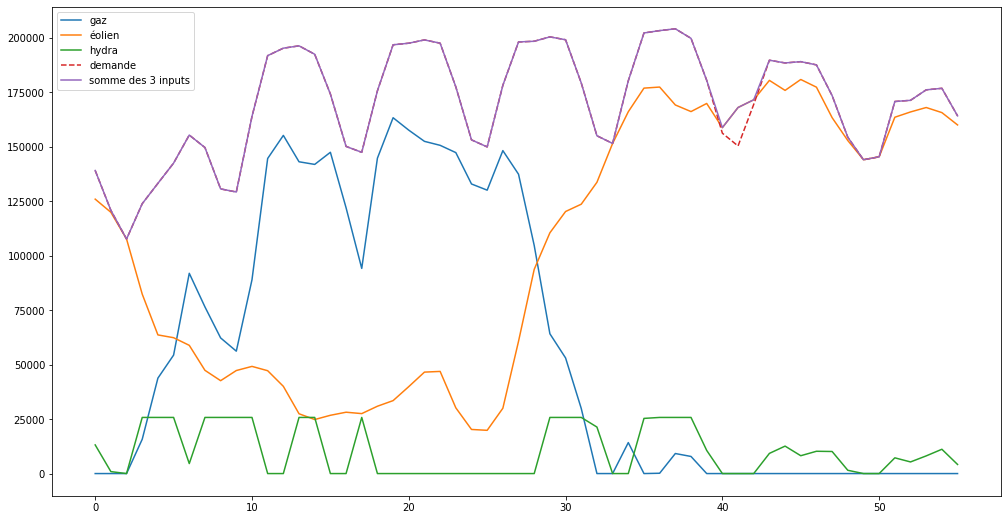

In [314]:
i = liste_pays.index('Allemagne')

plt.figure(figsize=(17,9))
plt.plot(solG_pays[i])
plt.plot(solE_pays[i])
plt.plot(solHd_pays[i])
plt.plot(D_pays[i], '--')
plt.plot(solG_pays[i]+solE_pays[i]+solHd_pays[i])
plt.legend(['gaz', 'éolien', 'hydra', 'demande', 'somme des 3 inputs'])
